In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import env
import acquire

### Acquistion: 
INITIAL ACQUISITION (only with assessed value, bathroom count, bedroom count, square feet

In [2]:
df = acquire.get_zillow_one('zillow')
df.head()

,Bedroom_Count,Bathroom_count,square_feet,Assessed_Value,transactiondate
0,3.0,2.0,1625,114106.0,2017-01-17
1,2.0,1.0,900,133000.0,2017-01-17
2,4.0,2.0,1112,92847.0,2017-01-17
3,3.0,2.0,1793,153604.0,2017-01-17
4,3.0,2.0,1140,73589.0,2017-01-17


### Acquistion Summary: 
Getting to know the data in dtypes, and any missed nulls from prep


In [3]:
#noting that transactiondate is the only non-numeric column. Do not think I will need to change that.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55847 entries, 0 to 56079
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Bedroom_Count    55847 non-null  float64
 1   Bathroom_count   55847 non-null  float64
 2   square_feet      55847 non-null  int64  
 3   Assessed_Value   55847 non-null  float64
 4   transactiondate  55847 non-null  object 
dtypes: float64(3), int64(1), object(1)
memory usage: 2.6+ MB


In [4]:
#No more nulls
df.isnull().sum()

Bedroom_Count      0
Bathroom_count     0
square_feet        0
Assessed_Value     0
transactiondate    0
dtype: int64

### Prep-Scale:

### Exploration and Visualization:

<AxesSubplot:xlabel='Bedroom_Count', ylabel='Assessed_Value'>

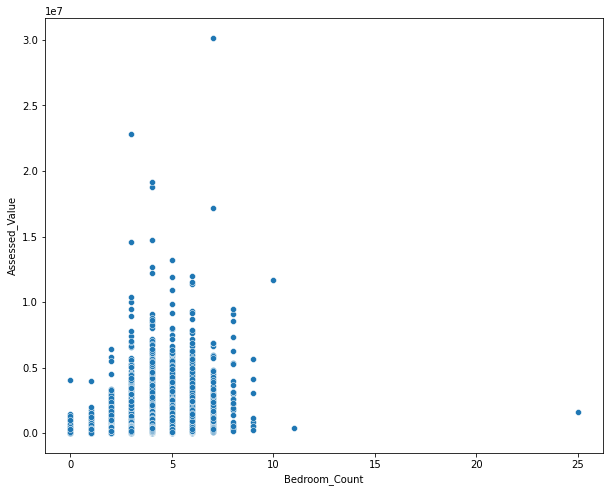

In [5]:
plt.figure(figsize=(10,8))
sns.scatterplot(data=df, x="Bedroom_Count", y="Assessed_Value")

### Exploration and Test:

<AxesSubplot:xlabel='Bedroom_Count', ylabel='square_feet'>

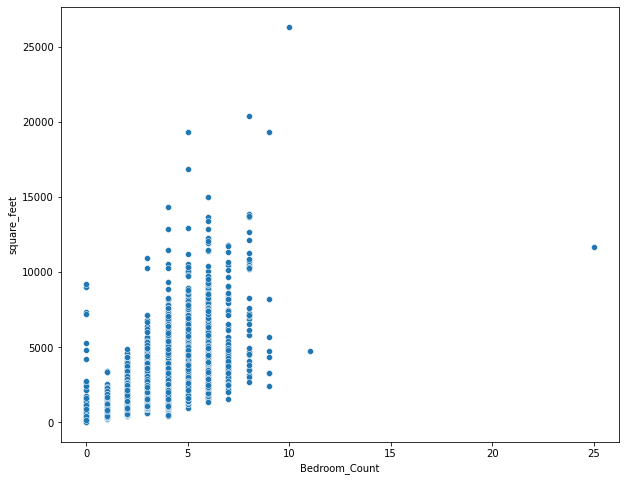

In [7]:
plt.figure(figsize=(10,8))
sns.scatterplot(data=df, x="Bedroom_Count", y="square_feet")